<a href="https://colab.research.google.com/github/ginttone/multi_deeplearning/blob/master/Naver_SentimentAnalysis_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터 다운로드(네이버 영화리뷰 데이터)

In [1]:
 !curl -O https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.9M  100 13.9M    0     0  9198k      0  0:00:01  0:00:01 --:--:-- 9193k


In [2]:
 !curl -O https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4778k  100 4778k    0     0  5827k      0 --:--:-- --:--:-- --:--:-- 5820k


## 데이터 전처리

In [3]:
import pandas as pd

In [4]:
train_data = pd.read_table('./ratings_train.txt')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [5]:
train_data.head(3)
#id 유니크값 | document  | label y값

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


 document  149995 non-null  object

 id와 label에 null 값이  있어서 drop시킨다

 train_data 에 그대로 저장 inplace=True 

In [6]:
train_data.dropna(inplace=True)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


만약에 데이터가 한쪽으로 쏠려있으면 언더(과소표집)나 오버핏팅(과대표집) 해서 데이터를 맞춰준다 .

지금 데이터는 별 차이 없음으로 그냥 진행

In [8]:
train_data['label'].value_counts()

0    75170
1    74825
Name: label, dtype: int64

각문장을 토큰화 시키기

In [9]:
 !python -m pip install konlpy

     |████████████████████████████████| 19.4 MB 1.4 MB/s 
     |████████████████████████████████| 86 kB 4.8 MB/s 
     |████████████████████████████████| 448 kB 40.4 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [10]:
import konlpy

임의 불용어 단어사전

In [11]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

원형으로 변환(분류기 사용)
 ```
 와 = 오다
 만드는 = 만들다 
 나을 = 나다 
 ```

In [12]:
okt = konlpy.tag.Okt()
okt.morphs('와 이런것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔',stem=True )

['오다', '이런', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

불용어로 걸러내기

 Okt = melcap 쪼개는 기능

 stem 어간추출

In [13]:
# train_data_small = train_data 인데 지금은 너무많으니까 제한둠
train_data_small = train_data[0:300]

In [35]:
Y_train = train_data['label'][0:300]
print(Y_train)

0      0
1      1
2      0
3      0
4      1
      ..
295    1
296    0
297    0
298    0
299    1
Name: label, Length: 300, dtype: int64


  words = list() # for문 내에서 담을 변수

  for tok in temp_x: #과대표집 , 불용어 추출

  if tok not in stopwords: #불용어가 아니면 저장


In [15]:
x_train = list()
okt = konlpy.tag.Okt()
for sentence in train_data_small['document']:
  temp_x = okt.morphs(sentence, stem=True)
  words = list()
  for tok in temp_x:
    if tok not in stopwords:
      words.append(tok)
  x_train.append(words)

x_train[3:5]

[['교도소', '이야기', '구먼', '..', '솔직하다', '재미', '없다', '..', '평점', '조정'],
 ['사이',
  '몬페',
  '그',
  '익살스럽다',
  '연기',
  '돋보이다',
  '영화',
  '!',
  '스파이더맨',
  '에서',
  '늙다',
  '보이다',
  '커스틴',
  '던스트',
  '너무나도',
  '이쁘다',
  '보이다']]

사전만들기 


In [16]:
import tensorflow as tf

In [17]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()

In [18]:
tokenizer.fit_on_texts(x_train)

In [21]:
print(tokenizer.word_index)

> word_index한번더 정재 해야하는 데 내일 이어서 공부할 예정

In [20]:
len(tokenizer.word_index)

1572

사전이용해 숫자로 바꾼다(인코딩)

In [22]:
X_train= tokenizer.texts_to_sequences(x_train)

In [30]:
## print(X_train[3:5])  #숫자화 됬는지 확인

x_train의 실제 전체 사이즈 중에 max와 min이 얼마인지 알아야 padding을 알 수 있다

전체를 히스토그램으로 그림을 그려 이정도 되겠네 알아내기

각 행의 len잡아보기

In [26]:
len(X_train[0]), len(X_train[2]), len(X_train[3]) # ...

(6, 8, 10)

In [29]:
hist = list()

for sent in X_train:
  hist.append(len(sent))

## print(hist) #각각의 길이 볼 수 있음

In [31]:
import matplotlib.pyplot as plt


(array([95., 96., 50., 20., 10.,  9.,  7.,  6.,  4.,  3.]),
 array([ 1. ,  6.6, 12.2, 17.8, 23.4, 29. , 34.6, 40.2, 45.8, 51.4, 57. ]),
 <a list of 10 Patch objects>)

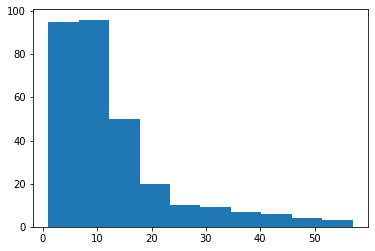

In [32]:
plt.hist(hist)

페딩 시퀀스(0으로 채워 줌)



In [33]:
 X_train = tf.keras.preprocessing.sequence.pad_sequences (X_train,maxlen=50)

In [34]:
X_train[3:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, 523, 146, 524,   4, 188,  80,   6,   4,  44, 525],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 526, 527,  38, 528,  15, 292,
          2,  16, 529,  28, 530, 118, 531, 532, 293, 189, 118]],
      dtype=int32)

In [36]:
X_train.shape, Y_train.shape

((300, 50), (300,))

In [39]:
import numpy as np
np.unique(Y_train)

array([0, 1])

## 모델

In [37]:
model = tf.keras.models.Sequential()

Embedding(1572, 50)

LSTM(64,activation='tanh')

Dense(1, activation='sigmoid'))

In [40]:
model.add(tf.keras.layers.Embedding(1572, 50))
model.add(tf.keras.layers.LSTM(64,activation='tanh'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy')

In [42]:
## model.fit(X_train, Y_train)